This is the analysis code used in the paper by Lecca et al. published in Cell Reports in 2020. The code below was written by Vijay Mohan K Namboodiri. Please direct any questions about the code to him. In order to minimize spams, the email address is as described below. The id is VijayMohan.KNamboodiri and the domain to which the email should be sent to is ucsf.edu

Any requests for data should be made to the corresponding author.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import subprocess
import time
import pandas
import pickle
import math
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import (StratifiedKFold, train_test_split,
                                     cross_val_score, LeaveOneOut, GridSearchCV)
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import sys
import re
from sklearn.naive_bayes import GaussianNB

/home/stuberlab/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
sns.set_style('ticks')
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.labelspacing'] = 0.2
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['lines.scale_dashes'] = False
mpl.rcParams['lines.dashed_pattern'] = (2, 1)
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['text.color'] = 'k'

## General functions

In [3]:
def binaryclassifier(y, X, cv):
    clf = GaussianNB()
    accuracies = cross_val_score(clf, X, y, cv=cv)  
    return accuracies

def run_binaryclassifier(y, X, filename, numshuffles=0, cv=5):    
    
#     start_time = time.time()
    accuracies = binaryclassifier(y, X, cv)
#     print 'Took %f seconds'%(time.time()-start_time)
    
    if type(accuracies)==np.ndarray:
        accuracy = np.mean(accuracies)
        if cv=='loo':
            tempcv = len(y)
        else:
            tempcv = cv
        shuffledresults = np.nan*np.ones((numshuffles, tempcv))
        for shuffleid in range(numshuffles):
            shuffled_y = np.random.permutation(y)
            shuffledresults[shuffleid,:] = binaryclassifier(shuffled_y, X, cv)

        
        shuffledresults = np.mean(shuffledresults, axis=1)
    else:
        accuracy = accuracies
        shuffledresults = np.nan*np.ones((numshuffles,))
        for shuffleid in range(numshuffles):
            shuffled_y = np.random.permutation(y)
            shuffledresults[shuffleid] = binaryclassifier(shuffled_y, X, cv)
        

    if filename:
        results = {}
        results['accuracies'] = accuracies
        results['shuffledresults'] = shuffledresults
        with open(filename, 'wb') as f:
            pickle.dump(results, f)    
    
    
    return accuracy, shuffledresults

def standardize_plot_graphics(ax):
    [i.set_linewidth(0.5) for i in ax.spines.itervalues()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax
    
def CDFplot(x, ax, color=None, label='', linetype='-'):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], linetype, color=color, label=label)
    return ax

def do_PCA(X, basedir='', condition='', show_plots=False):
    pca = PCA(n_components=X.shape[1], whiten=True)
    pca.fit(X) 

    transformed_data = pca.transform(X)
    pca_vectors = pca.components_
    print 'Number of PCs = %d'%(pca_vectors.shape[0])

    x = 100*pca.explained_variance_ratio_
    xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
    numpcs_tokeep = np.argmin(xprime)
    # Number of PCs to be kept is defined as the number at which the 
    # scree plot bends. This is done by simply bending the scree plot
    # around the line joining (1, variance explained by first PC) and
    # (num of PCs, variance explained by the last PC) and finding the 
    # number of components just below the minimum of this rotated plot
    print 'Number of PCs to keep = %d'%(numpcs_tokeep)
    
    if show_plots:
        fig, ax = plt.subplots(figsize=(2,2))
        ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
        ax.set_ylabel('Percentage of\nvariance explained')
        ax.set_xlabel('PC number')
        ax.axvline(numpcs_tokeep, linestyle='--', color='k', linewidth=0.5)
        ax.set_title('Scree plot')
        # ax.set_xlim([0,50])
        standardize_plot_graphics(ax)

        fig.subplots_adjust(left=0.3, right=0.98, bottom=0.25, top=0.9)
        fig.savefig(os.path.join(basedir, '%s Scree plot.pdf'%condition),
                    format='pdf')


        numcols = 3.0
        fig, axs = plt.subplots(int(np.ceil(numpcs_tokeep/numcols)), int(numcols),
                                sharey='all', sharex='all',
                                figsize=(1*numcols, 1*int(np.ceil(numpcs_tokeep/numcols))))
        for pc in range(numpcs_tokeep):
            ax = axs.flat[pc]
            ax.plot(pca_vectors[pc,:])
            ax.annotate(s='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
                        textcoords='axes fraction', multialignment='center', size='large')
            standardize_plot_graphics(ax)


        fig.text(0.5, 0.05, 'Features', horizontalalignment='center', rotation='horizontal')
        fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
        fig.tight_layout()
        for ax in axs.flat[numpcs_tokeep:]:
            ax.set_visible(False)

        fig.subplots_adjust(wspace=0.08, hspace=0.08, left=0.19, right=0.98,
                            bottom=0.1, top=0.96)
        fig.savefig(os.path.join(basedir, '%s PCA weights.pdf'%condition),
                    format='pdf')
    return transformed_data, numpcs_tokeep


def Benjamini_Hochberg_pvalcorrection(vector_of_pvals):
    # This function implements the BH FDR correction
    
    # Parameters:
    # Vector of p values from the different tests
    
    # Returns: Corrected p values.
    
    sortedpvals = np.sort(vector_of_pvals)
    orderofpvals = np.argsort(vector_of_pvals)
    m = sortedpvals[np.isfinite(sortedpvals)].size #Total number of hypotheses
    corrected_sortedpvals = np.nan*np.ones((sortedpvals.size,))
    corrected_sortedpvals[m-1] = sortedpvals[m-1]
    for i in range(m-2, -1, -1):
        corrected_sortedpvals[i] = np.amin([corrected_sortedpvals[i+1], sortedpvals[i]*m/(i+1)])
    correctedpvals = np.nan*np.ones((vector_of_pvals.size,))
    correctedpvals[orderofpvals] = corrected_sortedpvals
    return correctedpvals

# First, make example figure from one animal

In [5]:
basedir = '/home/stuberlab/Dropbox (Stuber Lab)/lecca and mameli/figures'

df1 = pd.read_excel(os.path.join(basedir, 'Example z-score Fig3.xlsx'),
                    sheetname='AL', header=1, index_col=0)
df2 = pd.read_excel(os.path.join(basedir, 'Example z-score Fig3.xlsx'),
                    sheetname='Runaway', header=1, index_col=0)

/home/stuberlab/anaconda/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/home/stuberlab/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


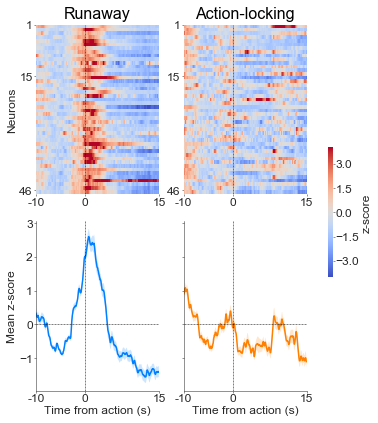

In [6]:
actionlocking = df1.values.astype(float).T
runaway = df2.values.astype(float).T
data = np.stack((runaway, actionlocking), axis=2)
timepoints = df1.index.values.astype(float)

pre_window_size = np.where(timepoints==0)[0][0]
window_size = len(timepoints)
framerate = 20.
cmax = 4 # Maximum colormap value. 

trial_types = ['Runaway', 'Action-locking']

colors_for_key = {}
colors_for_key[trial_types[0]] = (0,0.5,1)
colors_for_key[trial_types[1]] = (1,0.5,0)

fig, axs = plt.subplots(2,2,figsize=(3*2, 3*2), sharex='all', sharey='row')

cbar_ax = fig.add_axes([0.77, .35, .01, .3])
cbar_ax.tick_params(width=0.5) 

for t, trial_type in enumerate(trial_types):
    ax = axs[0, t]
    ax.set_title(trial_type)
    sns.heatmap(data[:, :, t],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=-cmax,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'z-score'})
    ax.grid(False)
    ax.tick_params(width=0.5)
    ax.set_xticks([0, pre_window_size, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               window_size]],
                       rotation=0)
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)   
#     ax.axvline(np.where(timepoints==0)[0][0], linestyle='--', color='k', linewidth=0.5)     
#     ax.set_xlabel('Time from action (s)')
    
        
    ax = axs[-1, t]
    sns.tsplot(data[:, :, t],
               ax=ax, color=colors_for_key[trial_type])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)   
    ax.set_xlabel('Time from action (s)')
    standardize_plot_graphics(ax)
    ax.set_xticks([0, pre_window_size, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               window_size]],
                       rotation=0)
    ax.axhline(0, linestyle='--', color='k', linewidth=0.5)  
    
    
    
axs[-1,0].set_ylabel('Mean z-score')
ax = axs[0, 0]
ax.set_ylabel('Neurons')
ax.set_yticks([0, 14, 45]) 
ax.set_yticklabels([str(int(a+1)) for a in [0, 14, 45]])

# axs[0,1].set_yticks([])



fig.tight_layout()
fig.subplots_adjust(right=0.72)

fig.savefig(os.path.join(basedir, 'Example figure.png'), format='png', dpi=300)
fig.savefig(os.path.join(basedir, 'Example figure.pdf'), format='pdf')

# Now do the full analysis

In [7]:
basedir = '/home/stuberlab/Dropbox (Stuber Lab)/lecca and mameli/reaction time corrected'

df1 = pd.read_excel(os.path.join(basedir, 'Decoding analysis.xlsx'),
                    sheetname='action locking', header=1, index_col=1)
df2 = pd.read_excel(os.path.join(basedir, 'Decoding analysis.xlsx'),
                    sheetname='Runaway', header=1, index_col=1)

if 'reaction time corrected' in basedir:
    df1 = df1.drop(labels=['trial n'], axis=1)
    df2 = df2.drop(labels=['trial n'], axis=1)

In [5]:
numneurons = 248
numtrials = 20 # initialize to a max of numtrials possible trials
timepoints = np.array(list(df1)).astype(float)
if 'corrected baseline' in basedir:
    end_looming_baseline = np.where(timepoints==0)[0][0]
else:
    end_looming_baseline = 0
timepoints = timepoints[end_looming_baseline:]
numtimepoints = len(timepoints)

actionlocking = np.nan*np.ones((numtrials, numtimepoints, numneurons))
runaway = np.nan*np.ones((numtrials, numtimepoints, numneurons))

for neuron in range(numneurons):
    temp = df1.loc[neuron+1, :].values.astype(float)
#     temp = (temp-np.mean(temp[:,60:120], axis=1)[:,None])/np.std(temp[:,60:120], axis=1)[:,None]
    actionlocking[:temp.shape[0], :, neuron] = temp[:,end_looming_baseline:]
    temp = df2.loc[neuron+1, :].values.astype(float)
#     temp = (temp-np.mean(temp[:,60:120], axis=1)[:,None])/np.std(temp[:,60:120], axis=1)[:,None]
    runaway[:temp.shape[0], :, neuron] = temp[:,end_looming_baseline:]
    
meandata = np.stack((np.nanmean(runaway, axis=0).T,
                     np.nanmean(actionlocking, axis=0).T), axis=2)
np.save(os.path.join(basedir, 'mean responses.npy'), meandata)

/home/stuberlab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: Mean of empty slice
/home/stuberlab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: Mean of empty slice


## Clustering set up

In [8]:
temp = np.load(os.path.join(basedir, 'mean responses.npy'))

if 'reaction time corrected' in basedir:
    temp1 = temp[:,np.where(np.abs(timepoints-(-0.5))<1E-5)[0][0]:,:]
    # Only count data from 0.5 s prior to action so as to not run into issues with missing
    # data for PCA

populationdata = np.concatenate((temp[:,:-1,0], temp[:,:-1,1]), axis=1)
# Remove last frame since original data counts 201 frames for 10 s.
populationdata_allpresent = np.concatenate((temp1[:,:-1,0], temp1[:,:-1,1]), axis=1)
# Remove last frame since original data counts 201 frames for 10 s.
print(temp.shape, populationdata.shape, populationdata_allpresent.shape)

((248, 201, 2), (248, 400), (248, 20))


Now, we will visualize the full dataset to get a sense of what they look like. As mentioned previously, the first 100 features correspond to CS+ responses and the last 100 features correspond to CS- responses. So I will plot both trial types separately.

In [9]:
framerate = 20
pre_window_size = int(3*framerate) # 3 seconds. Corresponds to baseline prior to actions.
window_size = int(10*framerate) # Total number of frames plotted around action
pre_window_size_allpresent = int(0.5*framerate) # Frames in which no neuron's data are missing
window_size_allpresent = int(7.5*framerate) # Total number of frames plotted around action
sort_end_period = int(7*framerate) # Sort by activity during this period

sortwindow = [pre_window_size_allpresent, pre_window_size_allpresent + sort_end_period] # Sort responses
sortresponse = np.argsort(np.mean(populationdata_allpresent[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 4 # Maximum colormap value. 

trial_types = ['Runaway', 'Action-locking']

colors_for_key = {}
colors_for_key[trial_types[0]] = (0,0.5,1)
colors_for_key[trial_types[1]] = (1,0.5,0)

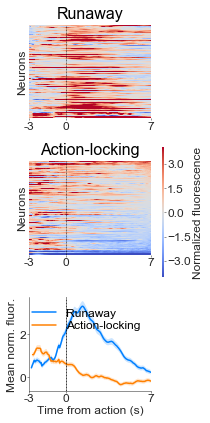

In [10]:
fig, axs = plt.subplots(3,1,figsize=(3*1,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.77, .35, .01, .3])
cbar_ax.tick_params(width=0.5) 

for t in range(len(trial_types)):
    ax = axs[t]
    ax.set_title(trial_types[t])
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=-cmax,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'Normalized fluorescence'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
#     ax.set_xticks([0, pre_window_size, window_size]) 
#     ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
#                                      for a in [0, pre_window_size,
#                                                window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)   
#     ax.axvline(np.where(timepoints==0)[0][0], linestyle='--', color='k', linewidth=0.5)     
#     ax.set_xlabel('Time from action (s)')
    ax.set_ylabel('Neurons')
        
    ax = axs[-1]
    sns.tsplot(populationdata[sortresponse, t*window_size:(t+1)*window_size],
               ax=ax, color=colors_for_key[trial_types[t]],
               condition=trial_types[t])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)   
#     ax.axvline(np.where(timepoints==0)[0][0], linestyle='--', color='k', linewidth=0.5)
    
    
    
    
axs[-1].set_ylabel('Mean norm. fluor.')
axs[-1].legend()       
axs[-1].set_xlabel('Time from action (s)')
standardize_plot_graphics(axs[-1])

for ax in axs:
    ax.set_xticks([0, pre_window_size, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               window_size]],
                       rotation=0)

fig.tight_layout()
fig.subplots_adjust(right=0.72)

fig.savefig(os.path.join(basedir, 'All neuron PSTH.png'), format='png', dpi=300)
fig.savefig(os.path.join(basedir, 'All neuron PSTH.pdf'), format='pdf')

Including all response features per neuron makes the feature space quite large. So, let us first reduce the dimensionality of this space using Principal Component Analysis

Number of PCs = 248
Number of PCs to keep = 7


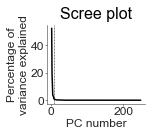

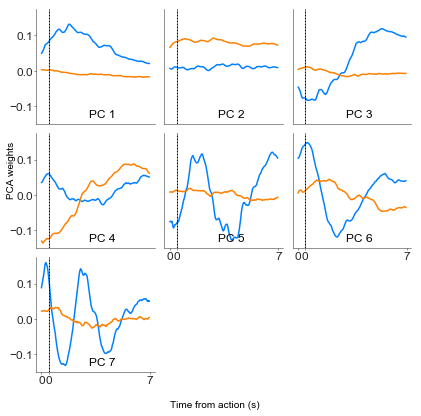

In [16]:
if os.path.isfile(os.path.join(basedir, 'pcaresults.pickle')):
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
else:
    pca = PCA(n_components=populationdata_allpresent.shape[1], whiten=True)
    pca.fit(populationdata_allpresent) 
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
    
transformed_data = pca.transform(populationdata_allpresent)

pca_vectors = pca.components_
print 'Number of PCs = %d'%(pca_vectors.shape[0])

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print 'Number of PCs to keep = %d'%(num_retained_pcs)

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
# ax.set_xlim([0,50])
[i.set_linewidth(0.5) for i in ax.spines.itervalues()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.8)
fig.savefig(os.path.join(basedir, 'scree plot.pdf'), format='pdf')

tempdata = np.stack((np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1,
                     x), axis=1)
np.savetxt(os.path.join(basedir, 'scree plot data.txt'),
           tempdata,
           fmt='%d %.3f',
           delimiter=',          ',
           header='PC       Var explained')

np.savetxt(os.path.join(basedir, 'pca vectors data.txt'),
           pca_vectors,
           fmt='%.3f',
           delimiter=',          ',
           header='Rows represent PC numbers. Columns are features. Different trials are %d blocks of columns'%(window_size_allpresent))


numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size_allpresent:(k+1)*window_size_allpresent],
                color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size_allpresent, linestyle='--', color='k', linewidth=1)
    ax.annotate(s='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
                textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size_allpresent,
                       window_size_allpresent])
        ax.set_xticklabels([str(int((a-pre_window_size_allpresent+0.0)/framerate))
                             for a in [0, pre_window_size_allpresent,
                                       window_size_allpresent]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.itervalues()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from action (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)
fig.savefig(os.path.join(basedir, 'principal components.pdf'), format='pdf')

## Perform clustering

Now, we have reduced the full dataset into a reduced dimensionality corresponding to the PCA subspace. 

Next, we will start the clustering. The approach we will use is Spectral Clustering. This is a pretty good method for dealing with high dimensional data. Note that even after PCA dimensionality reduction, there are 7 dimensions in this dataset. The choice of the method can affect the exact clustering results and there really is no "the best" algorithm. Thus, clustering is almost always the beginning of an investigation, rather than the end. In other words, the point of this clustering approach is not to say "There are 8 subpopulations of neurons in LHb for sure", but rather to test if these identified clusters can be mapped onto interesting features either in terms of their responses or in terms of their biological features (genes, anatomy etc).

The one issue with Spectral Clustering is that you have to pre-specify the number of clusters. However, there are ways to optimize this number by using metrics of "clusteredness". I use a common method: <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">silhouette score</a>. The one caveat of this method you need to specify a minimum of two clusters. In my experience, when the data truly do not contain any clusters, the minimum of two clusters identified will be quite obviously similar to each other. When data visualization clearly shows that the identified "clusters" are similar in terms of responses, one should conclude that there are no clusters.

This is the fundamental issue with approaches such as clustering. In the end, there are strong subjective elements to it. However, when there truly are clusters in the data, it can be a powerful approach to uncovering such structure. 

In our previous <a href="https://www.nature.com/articles/s41593-019-0408-1">paper</a>, I validated these identified clusters using two major approaches:

1. I found that the responses of neurons that were clustered on one day are stable on another day when the behavior is stable. Thus, the difference between clusters remains even on a cross-validation day.

2. Subpopulations of the output population studied here (e.g. OFC neurons projecting to VTA) comprise of only select clusters. This shows that specific types of responses are absent in specific downstream projections. Such a clear mapping of identified clusters to biology is a good indication that the clustering results are real.

In [10]:
max_n_clusters = 11 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([10, 30, 50, 100, 200]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print 'Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx])

print 'Done with model fitting'

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)

Done with numclusters = 2, num nearest neighbors = 10: score = 0.181
Done with numclusters = 2, num nearest neighbors = 30: score = 0.237
Done with numclusters = 2, num nearest neighbors = 50: score = 0.241
Done with numclusters = 2, num nearest neighbors = 100: score = 0.229
Done with numclusters = 2, num nearest neighbors = 200: score = 0.186
Done with numclusters = 3, num nearest neighbors = 10: score = 0.209
Done with numclusters = 3, num nearest neighbors = 30: score = 0.236
Done with numclusters = 3, num nearest neighbors = 50: score = 0.252
Done with numclusters = 3, num nearest neighbors = 100: score = 0.250
Done with numclusters = 3, num nearest neighbors = 200: score = 0.128
Done with numclusters = 4, num nearest neighbors = 10: score = 0.234
Done with numclusters = 4, num nearest neighbors = 30: score = 0.247
Done with numclusters = 4, num nearest neighbors = 50: score = 0.263
Done with numclusters = 4, num nearest neighbors = 100: score = 0.256
Done with numclusters = 4, nu

Next, we will reorder the cluster labels such that there is a fixed order for naming the clusters. This is important because if you run the previous code multiple times, it will return different orders for the cluster labels.

In [ ]:
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
# transformed_data = np.load(os.path.join(basedir, 'OFCCaMKII_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print n_clusters, n_nearest_neighbors

np.random.seed(1)
# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=2,
#                                 affinity='l2',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print 'Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp)

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(basedir, 'OFCCaMKII_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

Make a silhouette plot to visualize clustering quality. The average silhouette score above is the mean of all sample silhouettes. There are two other clustering methods commented out above (KMeans and agglomerative). One can see that if you apply those methods, the average silhouette score is lower, demonstrating that those methods are worse for these data. This also then shows that the high dimensional geometry for these data is unlikely to be a simple Gaussian structure, as these other methods are specialized for picking up Gaussian clusters. Spectral clustering is effective as it can uncover peculiarly shaped clusters

In [11]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

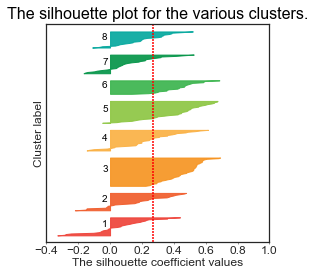

In [12]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

The average silhouette coefficient is about 0.2. As a general rule, this is a fairly low clustering quality index. However, if the range of spread of the data in the high dimensional space is fixed, silhouette score will necessarily be lower when there are many clusters in the data. Thus, this silhouette cannot by itself be used to argue against clustering in these data. This is why the clustering quality in this case needs to be verified through other means, such as projection specificity or response stability for clusters.

The neurons with negative silhouette scores are assigned to the wrong cluster. So one possible approach could be to run clustering multiple times (it's stochastic) and only select neurons that are reliably assigned to their corresponding cluster. This will improve cluster-wise inference for other analyses. However, I wanted to keep the analysis simpler and hence, decided not to do such filtering.

Plot the identified clusters. This plot is a good comparison to the original plot of the data, which did not cluster the data

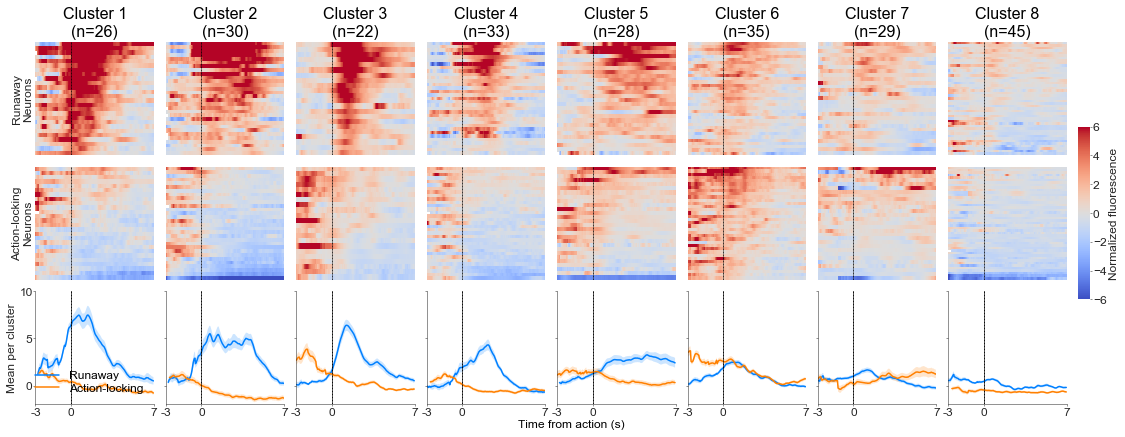

In [306]:
cmax = 6
sortwindow = [pre_window_size, window_size]

fig, axs = plt.subplots(len(trial_types)+1,len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*(len(trial_types)+1)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[k, cluster],
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence'})
        axs[k, cluster].grid(False)
        axs[k, cluster].set_xticks([])
        axs[k, cluster].set_yticks([])
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(np.where(timepoints==0)[0][0], linestyle='--', color='k', linewidth=0.5) 
        if cluster==0:
            axs[k, 0].set_ylabel('%s\nNeurons'%(tempkey))
        ax = axs[-1, cluster]
        if cluster==0:
            sns.tsplot(temp, ax=ax, color=colors_for_key[tempkey],
                       condition=tempkey)
            ax.set_ylabel('Mean per cluster')
        else:
            sns.tsplot(temp, ax=ax, color=colors_for_key[tempkey])
            ax.set_yticklabels([])
        ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        ax.axvline(np.where(timepoints==0)[0][0], linestyle='--', color='k', linewidth=0.5) 
        ax.set_ylim([-2, 10])
        standardize_plot_graphics(ax)
        ax.set_xticks([0, pre_window_size, window_size]) 
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   window_size]])
    axs[0, cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))
axs[-1, 0].legend(loc='lower right')
    
fig.text(0.5, 0.01, 'Time from action (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
# fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
# fig.subplots_adjust(bottom=0.2)
# fig.subplots_adjust(top=0.83)

fig.savefig(os.path.join(basedir, 'Clustering results.png'), format='png', dpi=300)
fig.savefig(os.path.join(basedir, 'Clustering results.pdf'), format='pdf')

In [307]:
numcells_per_animal = np.array([52, 74, 27, 95])
animals = ['Mouse '+str(a+1) for a in range(len(numcells_per_animal))]
cum_numcells_per_animal = np.concatenate((np.array([0]),np.cumsum(numcells_per_animal)))

uniquelabels = list(set(newlabels))
    
clusterlabels = {}

numneuronsperlabel = np.nan*np.ones((len(animals), len(uniquelabels)))
for a, animal in enumerate(animals):
    clusterlabels[animal] = newlabels[cum_numcells_per_animal[a]:cum_numcells_per_animal[a+1]]
    for l, label in enumerate(uniquelabels):
        numneuronsperlabel[a, l] = np.sum(clusterlabels[animal]==label)


df = pandas.DataFrame(data=numneuronsperlabel.astype(int),
                      columns=['Clus '+str(l+1) for l in uniquelabels],
                      index=animals).sort_index()
print df
df.to_csv(os.path.join(basedir, "Num neurons per cluster and animal.csv"))


         Clus 1  Clus 2  Clus 3  Clus 4  Clus 5  Clus 6  Clus 7  Clus 8
Mouse 1      16      10       0       7       3       6       7       3
Mouse 2       4       4      12       8       9      22       5      10
Mouse 3       4       9       0       8       1       1       0       4
Mouse 4       2       7      10      10      15       6      17      28


In [16]:
np.save(os.path.join(basedir, "newlabels.npy"), newlabels)

In [41]:
newlabels = np.load(os.path.join(basedir, "newlabels.npy"))
np.savetxt(os.path.join(basedir, "clusterlabelsforcell.txt"),
           np.stack((np.arange(len(newlabels))+1, newlabels+1), axis=1),
           header='Cell number     Cluster ID', fmt='%d',
           delimiter='                      ')

# Decoding

In [17]:
newlabels = np.load(os.path.join(basedir, "newlabels.npy"))

In [18]:
np.random.seed(1)

binsize = 3 # The size of a time bin over which decoding is performed
if 'corrected baseline' in basedir:
    window_start = 0
    window_end = 10
else:
    window_start = -3
    window_end = 7
starttimes = np.arange(window_start, window_end, binsize)
if np.abs(window_end-starttimes[-1]-binsize)>1E-5:
    starttimes = starttimes[:-1]

decoding_accuracies = np.nan*np.ones((numneurons, len(starttimes)))
decoding_nullaccuracies = np.nan*np.ones((numneurons, len(starttimes)))
ttestresults_all = np.nan*np.ones((len(starttimes), 2)) # t score, p value

mean_or_allframes = 'slope' # Take mean per bin or use all frames per bin
min_num_good_trials = 2 # Minimum number of trials with data for the given time bin and neuron
# If there are fewer trials than this for each action, set accuracy to nan for the neuron


# fig, axs = plt.subplots(1, len(starttimes), figsize=(3*len(starttimes), 3))

for s, starttime in enumerate(starttimes):
    endtime = starttime + binsize # in s
    startindex = int(np.where(np.abs(timepoints-starttime)<1E-5)[0][0])
    endindex = int(np.where(np.abs(timepoints-endtime)<1E-5)[0][0])
    for neuron in range(numneurons):
        tempnumtrials_actionlocking = np.sum(np.isfinite(np.nanmean(actionlocking[:,:,neuron],
                                                                    axis=1)))
        tempnumtrials_runaway = np.sum(np.isfinite(np.nanmean(runaway[:,:,neuron], axis=1)))
#         print(startindex, endindex, tempnumtrials_actionlocking, tempnumtrials_runaway)
    #     if np.amin([tempnumtrials_runaway, tempnumtrials_actionlocking])<6:
    #         continue
        data = np.concatenate((actionlocking[:tempnumtrials_actionlocking,
                                             startindex:endindex,neuron],
                               runaway[:tempnumtrials_runaway,
                                       startindex:endindex,neuron]))
        
#         tempnumtrials_actionlocking = 3
#         tempnumtrials_runaway = 3
#         data = np.random.normal(size=(tempnumtrials_actionlocking + tempnumtrials_runaway, 1))
        labels = np.concatenate((np.zeros((tempnumtrials_actionlocking)),
                                 np.ones((tempnumtrials_runaway))))
    
        labels = labels[np.isfinite(np.nanmean(data, axis=1))]
        data = data[np.isfinite(np.nanmean(data, axis=1)),:]
        
        if mean_or_allframes == 'mean':
            data = np.mean(data, axis=1)[:,None]
        elif mean_or_allframes == 'pca':
            pca = PCA(n_components=data.shape[1], whiten=False)
            pca.fit(data)

            data = pca.transform(data)[:,:1]
        elif mean_or_allframes == 'slope':
            
            temp = np.nan*np.ones((data.shape[0], 3)) # mean, slope and y-intercept
            for i in range(data.shape[0]):
                temp_idx = np.where(np.isfinite(data[i,:])==1)[0][0]
                lm = sm.OLS(data[i,temp_idx:],
                            sm.add_constant(np.arange(data[i,temp_idx:].shape[0]))).fit()
#                 temp[i, 0] = np.mean(data[i,temp_idx:])
                temp[i, 0] = lm.params[1]
                temp[i, 1] = lm.params[0]
                temp[i, 2] = np.std(data[i,temp_idx:])
                
            data = temp
        elif mean_or_allframes == 'all':
            data = data
         
        if np.amin([np.sum(labels==0), np.sum(labels==1)]) >= min_num_good_trials:
            decoding_accuracies[neuron, s], temp = \
            run_binaryclassifier(labels, data, '', cv='loo', numshuffles=10)
            decoding_nullaccuracies[neuron, s] = np.mean(temp)
        else:
            decoding_nullaccuracies[neuron, s] = np.nan

        

    print(starttime, np.sum(np.isfinite(decoding_accuracies[:,s])),
          np.mean(decoding_accuracies[np.isfinite(decoding_accuracies[:,s]), s]),
          np.mean(decoding_nullaccuracies[np.isfinite(decoding_nullaccuracies[:,s]), s]))
#     fig, ax = plt.subplots()
#     CDFplot(decoding_accuracies[:, s], axs[s], color='r', label='data')
#     CDFplot(decoding_nullaccuracies[:, s], axs[s], color='k', label='shuffled')
    ttestresults_all[s,:] = stats.ttest_ind(decoding_accuracies[np.isfinite(decoding_accuracies[:,s]), s],
                                            decoding_nullaccuracies[np.isfinite(decoding_accuracies[:,s]), s])
    ttestresults_all[s,1] *= 2 # One sided t test
#     print(np.mean(decoding_accuracies, axis=0))
#     break

/home/stuberlab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: Mean of empty slice
/home/stuberlab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: Mean of empty slice


(-3, 248, 0.50705972049826331, 0.46586649776113764)
(0, 248, 0.57366796104803608, 0.4671836825577092)
(3, 248, 0.55201033034910951, 0.46704083660823786)


In [19]:
ttestresults_all[:,1] = Benjamini_Hochberg_pvalcorrection(ttestresults_all[:,1])

In [10]:
ttestresults_all

array([[  3.22640765e+00,   2.67340707e-03],
       [  9.36923892e+00,   1.56148623e-18],
       [  7.53926598e+00,   6.83943808e-13]])

In [20]:
if 'corrected baseline' in basedir:
    starttimes -= 3 # Label axes ticks wrt action times

(0, (248,))
(1, (248,))
(2, (248,))
[[-3.          0.          3.        ]
 [ 0.04119322  0.10648428  0.08496949]
 [ 0.01274175  0.01134237  0.01124752]]


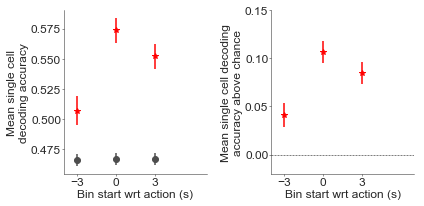

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))    

tempdatatosave = np.nan*np.ones((3, len(starttimes))) # starttimes, mean, sem

for s in range(len(starttimes)):
    if (ttestresults_all[s,1]<0.05) and (ttestresults_all[s,0]>0):
        color = 'r'
        marker = '*'
    else:
        color = 'k'
        marker = 'o'
        
    ax = axs[0]    
    temp = decoding_accuracies[np.isfinite(decoding_accuracies[:,s]), s]
    temp1 = decoding_nullaccuracies[np.isfinite(decoding_nullaccuracies[:,s]), s]
    print(s, temp.shape)
    ax.errorbar(starttimes[s], np.mean(temp),
                stats.sem(temp), color=color, marker=marker)
    ax.errorbar(starttimes[s], np.mean(temp1),
                stats.sem(temp1), color=0.3*np.ones((3,)),
                marker='o')
    
#     if s==0 or s==3:
#         ax.axvline(s, linestyle='--', color='k', linewidth=0.5) 
    
    
    ax = axs[1]
    sem_diff = np.sqrt(np.var(temp)/temp.shape[0]+
                       np.var(temp1)/temp1.shape[0])
    
    ax.errorbar(starttimes[s], 
                np.mean(temp)-np.mean(temp1),
                sem_diff, color=color, marker=marker)
    
    tempdatatosave[0, s] = starttimes[s]
    tempdatatosave[1, s] = np.mean(temp)-np.mean(temp1)
    tempdatatosave[2, s] = sem_diff
#     if s==0 or s==3:
#         ax.axvline(s, linestyle='--', color='k', linewidth=0.5) 
    
axs[0].set_ylabel('Mean single cell\ndecoding accuracy')
axs[1].set_ylabel('Mean single cell decoding\naccuracy above chance')
axs[1].set_ylim([-0.02, 0.15])
axs[1].axhline(0, color='k', ls='--', lw=0.5)

for ax in axs:
    ax.set_xlabel('Bin start wrt action (s)')
    ax.set_xlim([-4, 7])
    ax.set_xticks(starttimes)
    standardize_plot_graphics(ax)

fig.tight_layout()
fig.savefig(os.path.join(basedir,
                         'decoding accuracies for %s fluor per %ds bin.png'%(mean_or_allframes,
                                                                             binsize)),
            format='png', dpi=300)
fig.savefig(os.path.join(basedir,
                         'decoding accuracies for %s fluor per %ds bin.pdf'%(mean_or_allframes,
                                                                             binsize)),
            format='pdf')

print tempdatatosave

np.savetxt(os.path.join(basedir, 'decoding all neurons data.txt'),
           tempdatatosave,
           fmt='%.3f',
           delimiter=',          ',
           header='Rows are start times, mean accuracy and sem respectively.')

## Decoding accuracies per cluster

In [24]:
newlabels = np.load(os.path.join(basedir, 'newlabels.npy'))

In [25]:
clusters = list(set(newlabels))
ttestresults = np.nan*np.ones((len(starttimes), len(clusters), 2)) # t score, p value
for s in range(len(starttimes)):
    for c, cluster in enumerate(clusters):
        temp = np.where(newlabels==cluster)[0]
        temp1 = decoding_accuracies[temp, s]
        temp1 = temp1[np.isfinite(temp1)]
        temp2 = decoding_nullaccuracies[temp, s]
        temp2 = temp2[np.isfinite(temp2)]
        ttestresults[s,c,:] = stats.ttest_ind(temp1, temp2)

In [26]:
temp = Benjamini_Hochberg_pvalcorrection(np.ravel(ttestresults[:,:,1]))
ttestresults[:,:,1] = temp.reshape(ttestresults[:,:,1].shape)

In [18]:
ttestresults

array([[[  4.41294352e-01,   7.55317033e-01],
        [  1.17934985e-01,   9.06526654e-01],
        [  2.53793886e+00,   2.98977204e-02],
        [  1.20102658e+00,   2.95789882e-01],
        [  3.45731063e-01,   7.97332527e-01],
        [  2.58025747e+00,   2.62617516e-02],
        [  7.77863912e-01,   5.27908004e-01],
        [  1.93662679e+00,   7.90584497e-02]],

       [[  6.61599802e+00,   2.87281671e-07],
        [  5.02740309e+00,   4.06983622e-05],
        [  4.15506350e+00,   5.35487602e-04],
        [  4.19779001e+00,   3.39458817e-04],
        [  2.06664195e+00,   6.53656098e-02],
        [ -1.91909385e-01,   8.85271425e-01],
        [  2.25020563e+00,   4.54124711e-02],
        [  4.32964094e+00,   1.89202148e-04]],

       [[  3.12994200e+00,   7.77913835e-03],
        [  8.65645523e+00,   1.17909978e-10],
        [  2.98904420e+00,   1.11883311e-02],
        [  4.42880490e+00,   1.89202148e-04],
        [  3.26762859e+00,   5.66615231e-03],
        [ -2.44438976e+00,   3

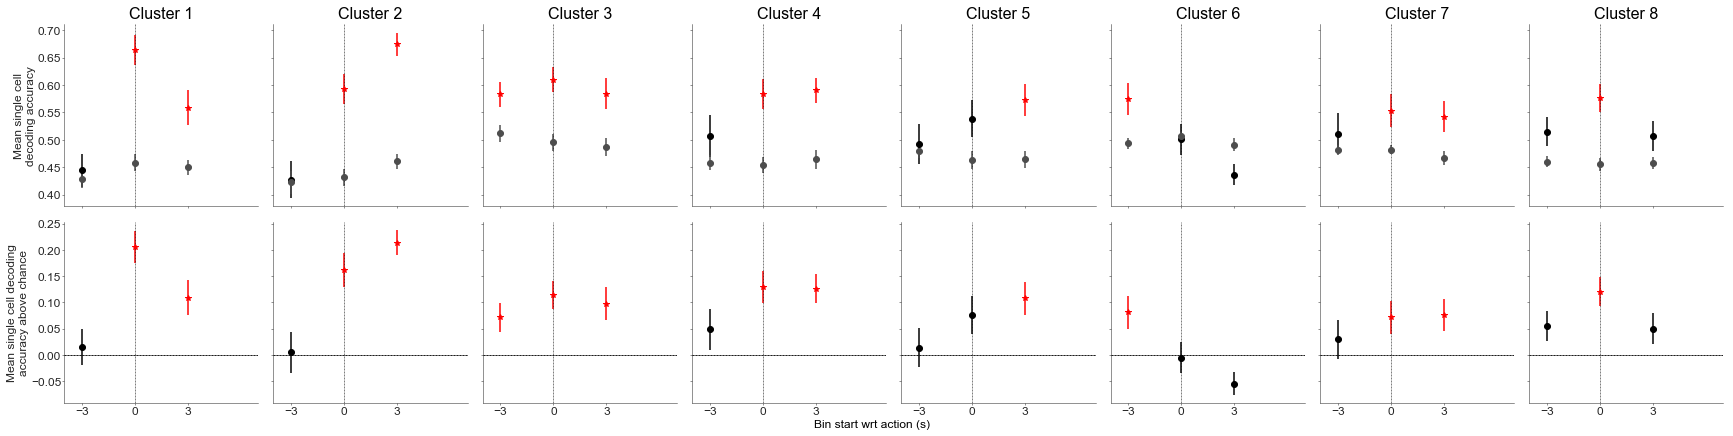

In [27]:
fig, axs = plt.subplots(2, len(clusters), figsize=(3*len(clusters), 3*2),
                        sharey='row', sharex='all')    

for s in range(len(starttimes)):
    for c, cluster in enumerate(clusters):
        temp = np.where(newlabels==cluster)[0]
        temp1 = decoding_accuracies[temp, s]
        temp1 = temp1[np.isfinite(temp1)]
        temp2 = decoding_nullaccuracies[temp, s]
        temp2 = temp2[np.isfinite(temp2)]
        
#         print(s, cluster+1, temp1.shape, temp2.shape)
        if (ttestresults[s,c,1]<0.05) and (ttestresults[s,c,0]>0):
            color = 'r'
            marker = '*'
        else:
            color = 'k'
            marker = 'o'

        ax = axs[0,c]    
        ax.errorbar(starttimes[s], np.mean(temp1),
                    stats.sem(temp1), color=color, marker=marker)
        ax.errorbar(starttimes[s], np.mean(temp2),
                    stats.sem(temp2), color=0.3*np.ones((3,)),
                    marker='o')
        if s==0:
            ax.axvline(s, linestyle='--', color='k', linewidth=0.5) 
        standardize_plot_graphics(ax)
        ax.set_title('Cluster %d'%(cluster+1))

        ax = axs[1,c]
        sem_diff = np.sqrt(np.var(temp1)/temp1.shape[0]+
                           np.var(temp2)/temp2.shape[0])

        ax.errorbar(starttimes[s], 
                    np.mean(temp1)-np.mean(temp2),
                    sem_diff, color=color, marker=marker)
        ax.set_xlim([-4, 7])
        ax.axhline(0, color='k', ls='--', lw=0.5)
        ax.set_xticks(starttimes)
        if s==0:
            ax.axvline(s, linestyle='--', color='k', linewidth=0.5) 
        standardize_plot_graphics(ax)
        
    
axs[0,0].set_ylabel('Mean single cell\ndecoding accuracy')
axs[1,0].set_ylabel('Mean single cell decoding\naccuracy above chance')

# for ax in axs:
#     ax.set_xlabel('Bin start (s)')
#     ax.set_xlim([-4, 7])
#     ax.set_xticks(starttimes)
fig.text(0.5, 0.01, 'Bin start wrt action (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.savefig(os.path.join(basedir,
                         'decoding accuracies per cluster for %s fluor per %ds bin.png'%(mean_or_allframes,
                                                                             binsize)),
            format='png', dpi=300)
fig.savefig(os.path.join(basedir,
                         'decoding accuracies per cluster for %s fluor per %ds bin.pdf'%(mean_or_allframes,
                                                                             binsize)),
            format='pdf')
    

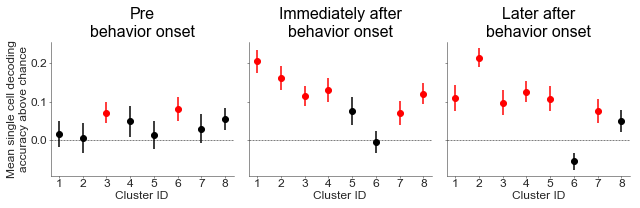

In [28]:
fig, axs = plt.subplots(1, len(starttimes), figsize=(3*len(starttimes), 3),
                        sharey='row', sharex='all')    

axes_titles = ['Pre\nbehavior onset', 'Immediately after\nbehavior onset',
               'Later after\nbehavior onset']

for s in range(len(starttimes)):
    ax = axs[s]
    tempdatatosave = np.nan*np.ones((3, len(clusters)))
    for c, cluster in enumerate(clusters):
        temp = np.where(newlabels==cluster)[0]
        temp1 = decoding_accuracies[temp, s]
        temp1 = temp1[np.isfinite(temp1)]
        temp2 = decoding_nullaccuracies[temp, s]
        temp2 = temp2[np.isfinite(temp2)]
        
#         print(s, cluster+1, temp1.shape, temp2.shape)
        if (ttestresults[s,c,1]<0.05) and (ttestresults[s,c,0]>0):
            color = 'r'
        else:
            color = 'k'
        marker = 'o'

        
        sem_diff = np.sqrt(np.var(temp1)/temp1.shape[0]+
                           np.var(temp2)/temp2.shape[0])

        ax.errorbar(cluster+1, 
                    np.mean(temp1)-np.mean(temp2),
                    sem_diff, color=color, marker=marker)
        tempdatatosave[0, c] = cluster+1
        tempdatatosave[1, c] = np.mean(temp1)-np.mean(temp2)
        tempdatatosave[2, c] = sem_diff
    np.savetxt(os.path.join(basedir, 'decoding all neurons starttime%d data.txt'%starttimes[s]),
               tempdatatosave,
               fmt='%.3f',
               delimiter=',          ',
               header='Rows are clusters, mean accuracy and sem respectively.')

    ax.axhline(0, color='k', ls='--', lw=0.5)
    ax.set_title(axes_titles[s])
    ax.set_xticks([clust+1 for clust in clusters])
    ax.set_xlabel('Cluster ID')
    standardize_plot_graphics(ax)
    
# axs[0,0].set_ylabel('Mean single cell\ndecoding accuracy')
axs[0].set_ylabel('Mean single cell decoding\naccuracy above chance')

# for ax in axs:
#     ax.set_xlabel('Bin start (s)')
#     ax.set_xlim([-4, 7])
#     ax.set_xticks(starttimes)
# fig.text(0.5, 0.01, 'Cluster ID', fontsize=12,
#          horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.savefig(os.path.join(basedir,
                         'decoding accuracies per epoch for %s fluor per %ds bin.png'%(mean_or_allframes,
                                                                             binsize)),
            format='png', dpi=300)
fig.savefig(os.path.join(basedir,
                         'decoding accuracies per epoch for %s fluor per %ds bin.pdf'%(mean_or_allframes,
                                                                             binsize)),
            format='pdf')
    

## Plot trials from neurons that had high decoding

/home/stuberlab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: Mean of empty slice


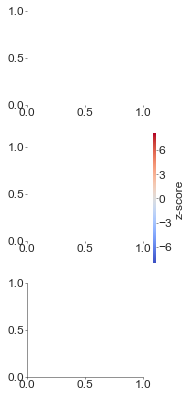

In [100]:
starttime_of_interest = 2 
# Set above to 0 for pre behavior onset, 1 for immediately after behavior onset
# and 2 for later after behavior onset.
temp = decoding_accuracies[:,starttime_of_interest]-\
       decoding_nullaccuracies[:, starttime_of_interest]
neurons = np.where(temp>0.3)[0]

cmax = 8

fig, axs = plt.subplots(3,1,figsize=(3*1,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.77, .35, .01, .3])
cbar_ax.tick_params(width=0.5)
for neuron in neurons:
    temp1 = runaway[:,:,neuron]
    temp2 = actionlocking[:,:,neuron]

    trialdata = np.stack((temp1, temp2), axis=2)

     

    for t in range(len(trial_types)):
        ax = axs[t]
        ax.set_title(trial_types[t])
        tempidx = np.where(np.isnan(np.nanmean(trialdata[:, :, t], axis=1)))[0][0]
        sns.heatmap(trialdata[:tempidx, :, t],
                    ax=ax,
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(t==0),
                    cbar_ax=cbar_ax if (t==0) else None,
                    cbar_kws={'label': 'z-score'})
        ax.grid(False)
        ax.tick_params(width=0.5)   
    #     ax.set_xticks([0, pre_window_size, window_size]) 
    #     ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
    #                                      for a in [0, pre_window_size,
    #                                                window_size]])
        ax.set_yticks(range(tempidx))
        ax.set_yticklabels([a+1 for a in range(tempidx)])
        ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)   
    #     ax.axvline(np.where(timepoints==0)[0][0], linestyle='--', color='k', linewidth=0.5)     
    #     ax.set_xlabel('Time from action (s)')
        ax.set_ylabel('Trial number')

        ax = axs[-1]
        sns.tsplot(trialdata[:tempidx, :, t],
                   ax=ax, color=colors_for_key[trial_types[t]],
                   condition=trial_types[t],
                   estimator=np.nanmean)
        ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)   
    #     ax.axvline(np.where(timepoints==0)[0][0], linestyle='--', color='k', linewidth=0.5)




    axs[-1].set_ylabel('Mean norm. fluor.')
    axs[-1].legend()       
    axs[-1].set_xlabel('Time from action (s)')
    standardize_plot_graphics(axs[-1])

    for ax in axs:
        ax.set_xticks([0, pre_window_size, window_size]) 
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   window_size]],
                           rotation=0)

    fig.tight_layout()
    fig.subplots_adjust(right=0.72)

    fig.savefig(os.path.join(basedir,'exampletrials',
                             'Trials from neuron %d.png'%(neuron+1)),
                format='png', dpi=300)
    fig.savefig(os.path.join(basedir, 'exampletrials',
                             'Trials from neuron %d.pdf'%(neuron+1)), format='pdf')
    for ax in axs:
        ax.clear()